# Homework 8

We now try to modify the code to change it into symmetric SNE. So we first need to understand the difference between t-SNE and symmetric SNE. The difference is in that symmetric SNE adopts Gaussian distribution for the calculation of pairwise similarities *in the lower dimension* while t-SNE uses student-t distribution which has much heavier tails than Gaussian to represent the pairwise distance. Note that both uses Gaussian to convert distance into probabilities in the high dimensional space. t-SNE solves the crowding problem as it strongly repels dissimilar datapoints in the low dimensional space as compared to SNE. Hence, what we need to do is to change the distribution of the lower dimensional distance representation, which is q.

In [39]:
import numpy as np
import pylab
import time


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, iteration=1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """
    
    # time it for performance
    start=time.time()
    
    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = iteration
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
            
    #print time taken
    endtime=str(time.time()-start)
    print("time taken: " + endtime + "s")

    # Return solution
    return Y

From the code above, we can see that the q-value is defined in the function t-sne(), where the t-distribution is used at line 130, `num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))`. We shall change it back into Gaussian distribution, replacing the line with `num = np.exp(-np.add(np.add(num, sum_Y).T, sum_Y))` for symmetric SNE.

In [40]:
def sym_sne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, iteration = 1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """
    
    # time it for performance
    start=time.time()

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = iteration
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        # num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))  #comment out student-t distribution
        num = np.exp(-np.add(np.add(num, sum_Y).T, sum_Y))   # Gaussian distribution
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    #print time taken
    endtime=str(time.time()-start)
    print("time taken: " + endtime + "s")        
    
    # Return solution
    return Y

We will now run both t-SNE and symmetric SNE to compare the two functions. Note that I have modified the original function slightly to limit the amount of print statements and included a timing function.   
   
We have also retained the other features of the implemented t-SNE in the symmetric SNE to optimize the cost function that might be different from the standard SNE implementation. For example, the code used "early exaggeration" which multiplied the value of pij by 4 in the initial stage(first 100 iterations in this case). This means that almost all of the qij ’s, which still add up to 1, are much too small to model their corresponding pij ’s. As a result, the optimization is encouraged to focus on modeling the large pij ’s by fairly large qij ’s. The effect is that the natural clusters in the data tend to form tight widely separated clusters in the map. This creates a lot of relatively empty space in the map, which makes it much easier for the clusters to move around relative to one another in order to find a good global organization.   
   
The number of gradient descent iterations T was set 1000, where in every iteration we compute the pairwise distance in low-dimension and the gradient, update the solution and momentum, and print progress every 100 iterations (originally 10). The momentum term is by set to 0.5 for t < 20 and 0.8 for t ≥ 20. In Laurens van der Maaten's paper and in his Matlab implementation, the momentum is supposed to change at iteration 250, but it was set to 20 in the python code, and I suspect this might be a typographical error. However, I will give the code the benefit of the doubt and use the original values.

tsne on default mnist dataset
Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.386597
Iteration 100: error is 15.989792
Iteration 200: error is 1.377934
Iteration 300: error is 1.185650
Iteration 400: error is 1.115041
Iteration 500: error is 1.080201
Iteration 600: error is 1.059493
Iteration 700: error is 1.046157
Iteration 800: error is 1.036885
Iteration 900: error is 1.030183
Iteration 1000: error is 1.025134
time taken: 877.1950917243958s


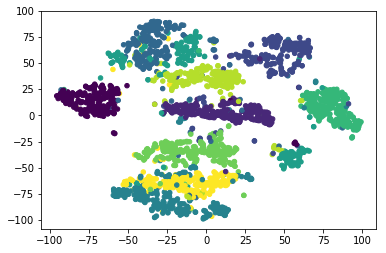

In [14]:
print("tsne on default mnist dataset")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = tsne(X, 2, 50, 20.0)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show();


Symmetric sne on default mnist dataset
Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.386597
Iteration 100: error is 18.737433
Iteration 200: error is 3.723571
Iteration 300: error is 5.612952
Iteration 400: error is 6.708787
Iteration 500: error is 7.294495
Iteration 600: error is 7.630480
Iteration 700: error is 7.878133
Iteration 800: error is 8.066381
Iteration 900: error is 8.202335
Iteration 1000: error is 8.301027
time taken: 1022.2448041439056s


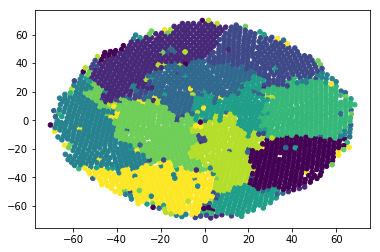

In [15]:
print("Symmetric sne on default mnist dataset")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = sym_sne(X, 2, 50, 20.0)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show();


From above, we see that symmetric SNE is more crowded than t-SNE. From the scale of the axis, we can also see that t-SNE's data is more spread out (-100 to 100 compared with -60 to 60). Both of them appeared to have a few wrongly outliers that lies within cluster of dissimlar data points(hence wrongly/badly projected), though it seems that symmetric SNE has more of them. However, aside from the minority of outliers, most of the clusters are well defined for both symmetric SNE and t-SNE(data of the same label are clustered together). However, due to the crowding in symmetric SNE, it would be almost impossible to identify the clusters without the label colouring. We observe that t-SNE gives much better visualisation of the clusters since they are further apart from each other.    
   
Interestingly, we may also notice that the error(cost function) of t-SNE converged more rapidly and reached a smaller cost value of approximately 1 at iteration 200, while symmetric SNE's error(cost function) only reached 3.7 at iteration, subsequently rising to 8.3 at 1000th iteration. This makes use wonder if symmetric SNE may perform better with lower iteration. We shall thus repeat the two visualisations with iteration=200.

tsne with 200 iterations
Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.386597
Iteration 100: error is 15.961920
Iteration 200: error is 1.366398
time taken: 187.25616478919983s


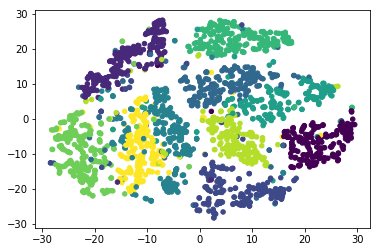

In [16]:
print("tsne with 200 iterations")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = tsne(X, 2, 50, 20.0,200)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show();


Symmetric sne with 200 iterations
Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.386597
Iteration 100: error is 19.362848
Iteration 200: error is 3.902155
time taken: 207.33359837532043s


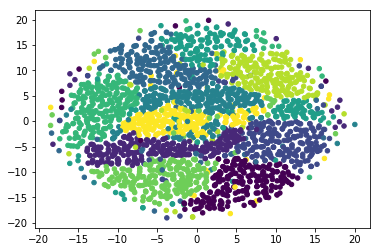

In [17]:
print("Symmetric sne with 200 iterations")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = sym_sne(X, 2, 50, 20.0,200)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show();


With 200 iterations, symmetric SNE does have a lower error. The clusters seems to be not as well-defined for both of the plots, though they are still fairly recognisable and probably good enough for use.   
   
We also notice that for both times, t-SNE took shorter time to run than symmetric SNE. However, 2 trials may be a small sample size and may not be reliable. We will hence run the trial 10 times with 200 iterations to test if t-SNE is indeed computationally faster than symmetric SNE. I will overwrite the above functions to run the trials without having to repeatedly print the progress statements.

In [63]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def timetrial(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, iteration=200, sne="s"):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """
    
    tottime=0   # Initialise total time taken
    
    for trials in range(10):
        # time it for performance
        start=time.time()

        # Check inputs
        if isinstance(no_dims, float):
            print("Error: array X should have type float.")
            return -1
        if round(no_dims) != no_dims:
            print("Error: number of dimensions should be an integer.")
            return -1

        # Initialize variables
        X = pca(X, initial_dims).real
        (n, d) = X.shape
        max_iter = iteration
        initial_momentum = 0.5
        final_momentum = 0.8
        eta = 500
        min_gain = 0.01
        Y = np.random.randn(n, no_dims)
        dY = np.zeros((n, no_dims))
        iY = np.zeros((n, no_dims))
        gains = np.ones((n, no_dims))

        # Compute P-values
        P = x2p(X, 1e-5, perplexity)
        P = P + np.transpose(P)
        P = P / np.sum(P)
        P = P * 4.									# early exaggeration
        P = np.maximum(P, 1e-12)

        # Run iterations
        for iter in range(max_iter):

            # Compute pairwise affinities
            sum_Y = np.sum(np.square(Y), 1)
            num = -2. * np.dot(Y, Y.T)
            if(sne=="t"):
                num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))  #student-t distribution
            if(sne=="s"):
                num = np.exp(-np.add(np.add(num, sum_Y).T, sum_Y))   # Gaussian distribution

            num[range(n), range(n)] = 0.
            Q = num / np.sum(num)
            Q = np.maximum(Q, 1e-12)

            # Compute gradient
            PQ = P - Q
            for i in range(n):
                dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

            # Perform the update
            if iter < 20:
                momentum = initial_momentum
            else:
                momentum = final_momentum
            gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                    (gains * 0.8) * ((dY > 0.) == (iY > 0.))
            gains[gains < min_gain] = min_gain
            iY = momentum * iY - eta * (gains * dY)
            Y = Y + iY
            Y = Y - np.tile(np.mean(Y, 0), (n, 1))

            # Compute current value of cost function
            if (iter + 1) % 100 == 0:
                C = np.sum(P * np.log(P / Q))

            # Stop lying about P-values
            if iter == 100:
                P = P / 4.

        #print time taken
        endtime=time.time()-start
        tottime+=endtime
    avetime=tottime/10
    print("Average time taken: " + str(avetime) + "s")

In [28]:
print("time trial for t-sne")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = timetrial(X, 2, 50, 20.0,200,"t")

time trial for t-sne
Average time taken: 190.91816544532776s


In [29]:
print("time trial for symmetric sne")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = timetrial(X, 2, 50, 20.0,200,"s")

time trial for symmetric sne
Average time taken: 214.89572575092316s


We see that t-SNE takes 190.91s on average while symmetric SNE takes 214.89s. This shows that t-SNE is indeed computationally faster than symmetric SNE.

## Visualizing the pdf in high dimensional space
We will also attempt to visualise the distribution of the pairwise similarity by plotting the pdf graph in both the high and low dimension.

The pairwise similarity in the high dimension can be found in the function x2p, where D is the similarity matrix. I extracted out the similarity matrix from the function, used numpy to find its mean and variance, then plotted its pdf graph with matplotlib by modelling the normal distribution with the mean, variance, and range of data. The graph below shows the pdf distribution of the pairwise similarity in the high dimension. Both t-SNE and symmetric SNE will have the same representation as they use the same similarity matrix to compute the P, since they only differ in the distribution of the low dimension.

Preprocessing the data using PCA...
Computing pairwise distances...
Miu: 120.92781258247172
Sigma-squared: 1035.7153930994689
Sigma: 32.18253242209924


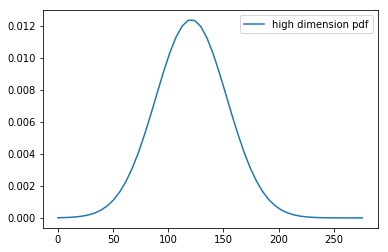

In [62]:
from scipy.stats import norm
import matplotlib.pyplot as plt

X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
X = pca(X, 50).real
print("Computing pairwise distances...")
(n, d) = X.shape
sum_X = np.sum(np.square(X), 1)
D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)    # similarity matrix
matmean = np.mean(np.mean(D,1))
print("Miu: " + str(matmean))
matvar = np.mean(np.var(D,0))
print("Sigma-squared: " +  str(matvar))
matsd = np.sqrt(matvar)
print("Sigma: " + str(matsd))
dmin=D.min()
dmax=D.max()
data = np.linspace(dmin,dmax)
y_pdf = norm.pdf(data, matmean, matsd) # the normal pdf
plt.plot(data, y_pdf, label='high dimension pdf')
plt.legend();

   
Now we shall plot the low dimension pairwise similarity, indicated by the matrix "num".

In [92]:
def plotlowdim(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, iteration=1000, sne="t"):

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = iteration
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        if(sne=="t"):
            num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))  #student-t distribution
        if(sne=="s"):
            num = np.exp(-np.add(np.add(num, sum_Y).T, sum_Y))   # Gaussian distribution
        print(num)
        matmean = np.mean(np.mean(num,1))
        print("Miu: " + str(matmean))
        matvar = np.mean(np.var(num,0))
        print("Sigma-squared: " +  str(matvar))
        matsd = np.sqrt(matvar)
        print("Sigma: " + str(matsd))
        nmin=num.min()
        nmax=num.max()
        print(nmin,nmax)
        data = np.linspace(nmin,nmax)
        y_pdf = norm.pdf(data, matmean, matsd) # the normal pdf
        plt.plot(data, y_pdf, label='low dimension pdf');

tsne 
[[1.         0.32556027 0.32798372 ... 0.28266485 0.14863927 0.62941336]
 [0.32556027 1.         0.47735202 ... 0.49635475 0.29088563 0.1894232 ]
 [0.32798372 0.47735202 1.         ... 0.96211277 0.51529479 0.17139701]
 ...
 [0.28266485 0.49635475 0.96211277 ... 1.         0.60950575 0.15235143]
 [0.14863927 0.29088563 0.51529479 ... 0.60950575 1.         0.09107095]
 [0.62941336 0.1894232  0.17139701 ... 0.15235143 0.09107095 1.        ]]
Miu: 0.3349163559065419
Sigma-squared: 0.04597770072695205
Sigma: 0.21442411414519602
0.016157995519634837 1.0000000000000036


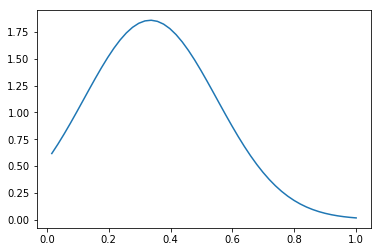

In [87]:
print("tsne ")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
plotlowdim(X, 2, 50, 20.0,1,"t")

symmetric sne 
[[1.00000000e+00 8.13750779e-01 6.17269562e-01 ... 6.14563016e-02
  4.72751392e-12 5.03311878e-02]
 [8.13750779e-01 1.00000000e+00 2.70125089e-01 ... 1.12026481e-02
  6.05163442e-14 2.89416966e-02]
 [6.17269562e-01 2.70125089e-01 1.00000000e+00 ... 3.85934936e-01
  2.66744998e-09 3.43396728e-02]
 ...
 [6.14563016e-02 1.12026481e-02 3.85934936e-01 ... 1.00000000e+00
  3.52108235e-06 4.34653845e-03]
 [4.72751392e-12 6.05163442e-14 2.66744998e-09 ... 3.52108235e-06
  1.00000000e+00 3.69076347e-15]
 [5.03311878e-02 2.89416966e-02 3.43396728e-02 ... 4.34653845e-03
  3.69076347e-15 1.00000000e+00]]
Miu: 0.1989575540965033
Sigma-squared: 0.0636902389186815
Sigma: 0.2523692511354771
2.652861387943507e-26 1.0000000000000036


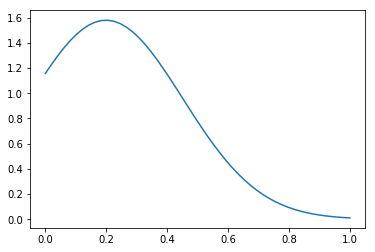

In [88]:
print("symmetric sne ")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
plotlowdim(X, 2, 50, 20.0,1,"s")

   
We now also try to visualise how the distribution change along the 200 iterations:

In [95]:
def plotlowdim(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, iteration=1000, sne="t"):

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = iteration
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        if(sne=="t"):
            num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))  #student-t distribution
        if(sne=="s"):
            num = np.exp(-np.add(np.add(num, sum_Y).T, sum_Y))   # Gaussian distribution
        matmean = np.mean(np.mean(num,1))
        matvar = np.mean(np.var(num,0))
        matsd = np.sqrt(matvar)
        nmin=num.min()
        nmax=num.max()
        data = np.linspace(nmin,nmax)
        y_pdf = norm.pdf(data, matmean, matsd) # the normal pdf
        plt.plot(data, y_pdf, label='low dimension pdf');
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

    # Stop lying about P-values
        if iter == 100:
            P = P / 4.

tsne 


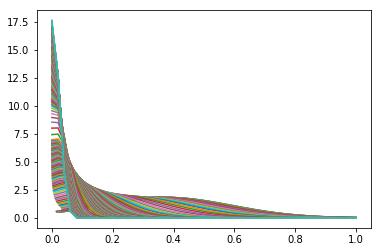

In [96]:
print("tsne ")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
plotlowdim(X, 2, 50, 20.0,200,"t")

symmetric sne 


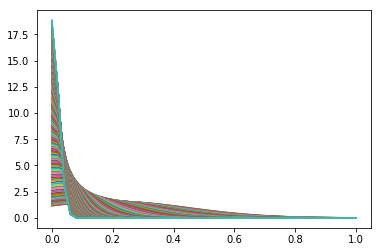

In [97]:
print("symmetric sne ")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
plotlowdim(X, 2, 50, 20.0,200,"s")

We can see that the distribution moves from the right to the left and converves towards the origin until it peaks, for both SNEs. t-SNE's distribution moves faster as indicated by the gaps in the graph compared to the smooth gradient of symmetric SNE.

### Visualising embedding in high dimension
We also try to visualise the higher dimension embeddings by tweaking the no_dims parameter from 2 to 20 and 50 for both SNEs:

tsne in high dimension (20)
Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.386597
Iteration 100: error is 15.664021
Iteration 200: error is 1.160507
time taken: 278.3838007450104s


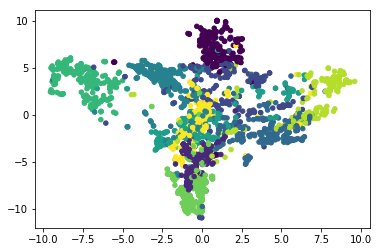

tsne in high dimension (50)
Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.386597
Iteration 100: error is 15.718810
Iteration 200: error is 1.164407
time taken: 487.65020418167114s


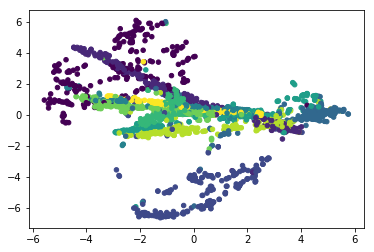

In [53]:
print("tsne in high dimension (20)")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = tsne(X, 20, 50, 20.0,200)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show();

print("tsne in high dimension (50)")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = tsne(X, 50, 50, 20.0,200)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show();

symmetric sne in high dimension(20)
Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.386597
Iteration 100: error is 68.009254
Iteration 200: error is 15.589932
time taken: 302.36648750305176s


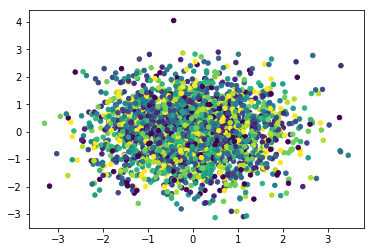

symmetric sne in high dimension(50)
Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.386597
Iteration 100: error is 72.172769
Iteration 200: error is 16.656894
time taken: 524.89293384552s


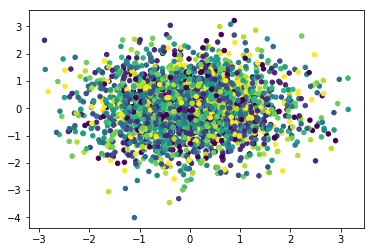

In [61]:
print("symmetric sne in high dimension(20)")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = sym_sne(X, 20, 50, 20.0,200)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show();

print("symmetric sne in high dimension(50)")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = sym_sne(X, 50, 50, 20.0,200)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show();

As we can see from above, at no_dims>2, crowding is still a problem for both t-SNE and symmetric SNE. However, clusters are still recognisable in t-SNE even though they overlap, as compared to symmetric SNE which is just a ball of mess.
   
   
## Adjusting perplexity
Perplexity is a measure for information that is defined as 2 to the power of the Shannon entropy. In t-SNE, the perplexity may be viewed as a knob that sets the number of effective nearest neighbors. It is comparable with the number of nearest neighbors k that is employed in many manifold learners. It will directly affect the cost function of the SNE. The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50, which will be the values that we will test on. The most appropriate value depends on the density of the data. Loosely speaking, one could say that a larger / denser dataset requires a larger perplexity. Again, we will only be using 200 iterations for the sake of conserving computational time.

t-sne, Perplexity = 5
Iteration 100: error is 17.798672
Iteration 200: error is 1.769836
time taken: 200.7160074710846s


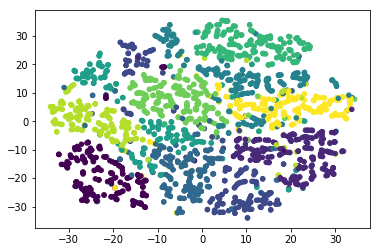

symmetric sne, Perplexity = 5
Iteration 100: error is 29.011755
Iteration 200: error is 5.266978
time taken: 242.7311305999756s


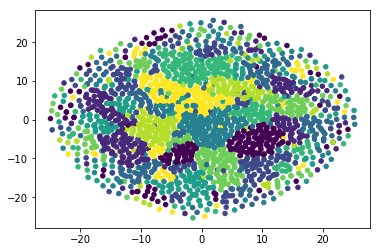

t-sne, Perplexity = 15
Iteration 100: error is 16.248009
Iteration 200: error is 1.434437
time taken: 203.4320192337036s


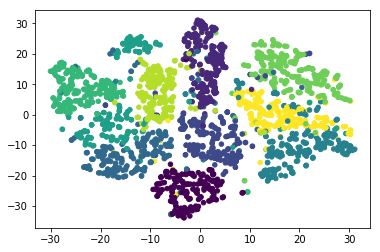

symmetric sne, Perplexity = 15
Iteration 100: error is 19.735900
Iteration 200: error is 3.743037
time taken: 228.43672513961792s


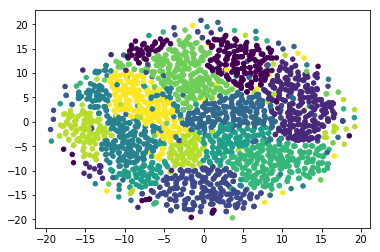

t-sne, Perplexity = 25
Iteration 100: error is 15.843583
Iteration 200: error is 1.316450
time taken: 223.57683181762695s


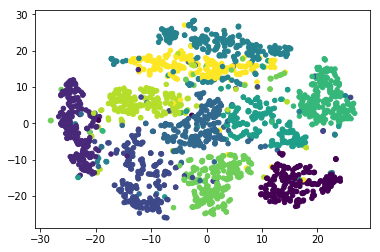

symmetric sne, Perplexity = 25
Iteration 100: error is 18.353035
Iteration 200: error is 3.899793
time taken: 341.3302319049835s


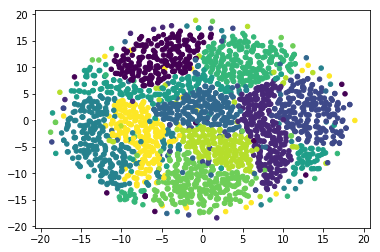

t-sne, Perplexity = 35
Iteration 100: error is 15.310926
Iteration 200: error is 1.188328
time taken: 467.77488827705383s


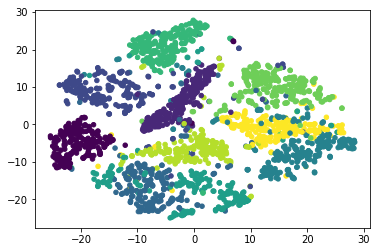

symmetric sne, Perplexity = 35
Iteration 100: error is 17.799316
Iteration 200: error is 4.118211
time taken: 495.18368577957153s


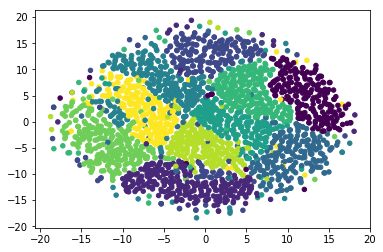

t-sne, Perplexity = 50
Iteration 100: error is 15.118483
Iteration 200: error is 1.098402
time taken: 480.402827501297s


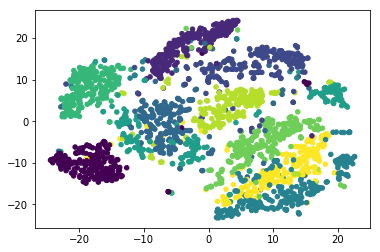

symmetric sne, Perplexity = 50
Iteration 100: error is 17.146098
Iteration 200: error is 4.466006
time taken: 521.8548624515533s


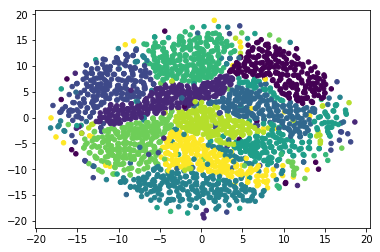

In [98]:
perplist = [5,15,25,35,50]
for i in perplist:
    print("t-sne, Perplexity = " + str(i))
    Y = tsne(X, 2, 50, i, 200)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show();
    print("symmetric sne, Perplexity = " + str(i))
    Y = sym_sne(X, 2, 50, i, 200)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show();

For all the perplexity, it would still be impossible to identify the clusters for symmetric SNE due to the crowding. However, if we are only looking at the correctness of the projection, I would think symmetric SNE performed best at perplexity = 25 or 35. As for t-SNE, I would think perplexity = 35 yielded the best results.